# Projet : Temporal data analysis

## Objectif: 
### Construire un système de prévision de la consommation d'électricité française (nationales et régionales) à horizon J+1 avec de données de résolution 30 min.

## Get data

### Les fichiers .py eco2mix et meteo ont permis de récupérer directement les données depuis les sites de Rte et de météo France.

## Preprocessing data

### Eco2mix

In [2]:
REGIONS = [
    "Auvergne-Rhône-Alpes",
    "Bourgogne-Franche-Comté",
    "Bretagne",
    "Centre-Val-de-Loire",
    "Grand-Est",
    "Hauts-de-France",
    "Ile-de-France",
    "Normandie",
    "Nouvelle-Aquitaine",
    "Occitanie",
    "PACA",
    "Pays-de-la-Loire"
]

FILETYPES = [
    "En-cours-Consolide",
    "En-cours-TR",
    "Annuel-Definitif_2013",
    "Annuel-Definitif_2014",
    "Annuel-Definitif_2015",
    "Annuel-Definitif_2016",
    "Annuel-Definitif_2017",
    "Annuel-Definitif_2018",
    "Annuel-Definitif_2019",
    "Annuel-Definitif_2020",
]


In [2]:
#importation des packages
import warnings
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from math import sqrt

warnings.filterwarnings("ignore")

In [5]:
#fonction pour créer le dataframe de consommation régionale
def add_conso_regional(region) :
    concat_df = pd.DataFrame()
    for filetype in FILETYPES:
        filename = f"./data/eco2mix/{region}/{filetype}.txt"
        df = pd.read_csv(filename, sep="\t", encoding="latin-1")
            #delete last row with comment of rte
        df = df[:-1]
        if filetype != "Annuel-Definitif_2019":
                #delete all columns except Date, Heure and Consommation
            df = df[["Date", "Heures", "Consommation"]]
        else:
                #delete all columns except Date, Heure and Consommation
            df = df[["Périmètre", "Nature", "Date"]]
            #rename columns
        df.columns = ["Date", "Heures", f"Consommation_{region}"]
            #put date and hour in index
        df = df.set_index(["Date", "Heures"])
        #delete all rows with NaN values
        df = df.dropna()
        #concatenate all dataframes
        concat_df = pd.concat([concat_df, df], axis=0)
        #replace nd by nan
        concat_df = concat_df.replace("ND", np.nan)
        concat_df[f"Consommation_{region}"] = concat_df[f"Consommation_{region}"].astype(float)
        concat_df = concat_df.sort_index()
    return concat_df

In [6]:
#boucle sur la fonction pour avoir un dataframe pour chaque région
conso_regional = pd.DataFrame()

for region in REGIONS:
    data = add_conso_regional(region)
    #concat dataframes for each region
    conso_regional = pd.concat([conso_regional, data], axis=1)
    #replace nan 
    conso_regional = conso_regional.fillna(method="bfill")

#reset index and create column index
conso_regional = conso_regional.reset_index()
conso_regional = conso_regional[~conso_regional["Heures"].str.contains("5")]
conso_regional["index"] = pd.to_datetime(conso_regional["Date"] + " " + conso_regional["Heures"])
#delete columns Date and Heures
conso_regional = conso_regional.drop(["Date", "Heures"], axis=1)


In [6]:
conso_regional

,Consommation_Auvergne-Rhône-Alpes,Consommation_Bourgogne-Franche-Comté,Consommation_Bretagne,Consommation_Centre-Val-de-Loire,Consommation_Grand-Est,Consommation_Hauts-de-France,Consommation_Ile-de-France,Consommation_Normandie,Consommation_Nouvelle-Aquitaine,Consommation_Occitanie,Consommation_PACA,Consommation_Pays-de-la-Loire,index
0,8173.0,2357.0,3050.0,2476.0,4943.0,5989.0,9134.0,3683.0,5464.0,5228.0,5570.0,3595.0,2013-01-01 00:00:00
1,8173.0,2357.0,3050.0,2476.0,4943.0,5989.0,9134.0,3683.0,5464.0,5228.0,5570.0,3595.0,2013-01-01 00:30:00
2,7944.0,2289.0,2866.0,2319.0,4811.0,5832.0,8822.0,3549.0,5422.0,4955.0,5698.0,3359.0,2013-01-01 01:00:00
3,7896.0,2326.0,2735.0,2560.0,4840.0,5926.0,8499.0,3570.0,5514.0,4888.0,5680.0,3313.0,2013-01-01 01:30:00
4,7882.0,2409.0,2874.0,2395.0,4897.0,5695.0,8229.0,3569.0,5443.0,4881.0,5577.0,3383.0,2013-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219482,8553.0,2663.0,2767.0,2334.0,5444.0,5965.0,9186.0,3162.0,5545.0,5422.0,4946.0,4035.0,2023-12-20 06:30:00
219484,8872.0,2777.0,2957.0,2583.0,5612.0,6225.0,9588.0,3339.0,5999.0,5634.0,5137.0,4104.0,2023-12-20 07:00:00
219486,8950.0,2855.0,3072.0,2630.0,5675.0,6336.0,10289.0,3407.0,6348.0,5818.0,5205.0,4148.0,2023-12-20 07:30:00
219488,9214.0,2910.0,3129.0,2772.0,5844.0,6601.0,10699.0,3469.0,6754.0,5979.0,5331.0,4081.0,2023-12-20 08:00:00


In [7]:
#check nan
conso_regional.isna().sum()

Consommation_Auvergne-Rhône-Alpes       0
Consommation_Bourgogne-Franche-Comté    0
Consommation_Bretagne                   0
Consommation_Centre-Val-de-Loire        0
Consommation_Grand-Est                  0
Consommation_Hauts-de-France            0
Consommation_Ile-de-France              0
Consommation_Normandie                  0
Consommation_Nouvelle-Aquitaine         0
Consommation_Occitanie                  0
Consommation_PACA                       0
Consommation_Pays-de-la-Loire           0
index                                   0
dtype: int64

In [7]:
#création d'un dataframe de la consommation nationale d'électricité
conso_national = pd.DataFrame()

for filetype in FILETYPES:
    filename = f"./data/eco2mix/France/{filetype}.txt"
    df = pd.read_csv(filename, sep="\t", encoding="latin-1", on_bad_lines='skip')
    df = df[:-1]
    if filetype == "En-cours-Consolide":
        #delete all columns except Date, Heure and Consommation
        df = df[["Date", "Heures", "Consommation"]]
    else:
        #delete all columns except Date, Heure and Consommation
        df = df[["Nature", "Date", "Heures"]]
    #rename columns
    df.columns = ["Date", "Heures", "Consommation"]
    #delete rows heures with a 5 in minutes
    df = df[~df["Heures"].str.contains(":.5")]
    #put date and hour in index
    df = df.set_index(["Date", "Heures"])
    #delete all rows with NaN values
    df = df.dropna()
    conso_national = pd.concat([conso_national, df], axis=0)
print(conso_national.sort_index())

                   Consommation
Date       Heures              
2013-01-01 00:00        61194.0
           00:30        59674.0
           01:00        57877.0
           01:30        57755.0
           02:00        57243.0
...                         ...
2023-12-20 12:00        66012.0
           12:30        64891.0
           13:00        63859.0
           13:30        63326.0
           14:00        63009.0

[187853 rows x 1 columns]


In [8]:
#Queleues modifications pour avoir un dataframe exploitable
conso_national = conso_national.sort_index()
conso_national = conso_national.reset_index()
conso_national = conso_national[~conso_national["Heures"].str.contains("5")]
conso_national = conso_national.set_index(["Date", "Heures"])
#concat date et heures columns and reset index
conso_national = conso_national.reset_index()
conso_national["index"] = conso_national["Date"] + " " + conso_national["Heures"]
#delete date and heures columns$
conso_national = conso_national.drop(columns=["Date", "Heures"])
print(conso_national)

        Consommation             index
0            61194.0  2013-01-01 00:00
1            59674.0  2013-01-01 00:30
2            57877.0  2013-01-01 01:00
3            57755.0  2013-01-01 01:30
4            57243.0  2013-01-01 02:00
...              ...               ...
172194       66012.0  2023-12-20 12:00
172195       64891.0  2023-12-20 12:30
172196       63859.0  2023-12-20 13:00
172197       63326.0  2023-12-20 13:30
172198       63009.0  2023-12-20 14:00

[172199 rows x 2 columns]


In [10]:
#check nan
conso_national.isna().sum()

Consommation    0
index           0
dtype: int64

### Meteo (temperature)

In [9]:
FILETYPES = [
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
    "2018",
    "2019",
    "2020",
    "2021",
    "2022",
    "2023",
]

FILES = [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
]

In [10]:
meteo = pd.DataFrame()

for filetype in FILETYPES:
    for file in FILES:
        filename = f"./data/meteo/{filetype}/{file}.csv"
        df = pd.read_csv(filename, sep=";")
        df = df[["numer_sta", "date", "t"]]
        #rename columns
        df.columns = ["id_station", "Date", "Temperature"]
        #delete rows by some id_station
        df = df[df.id_station != 7761]
        df = df[df.id_station != 7790]
        df = df[df.id_station != 7207]
        df = df[df.id_station != 61968]
        df = df[df.id_station != 61970]
        df = df[df.id_station != 61972]
        df = df[df.id_station != 61976]
        df = df[df.id_station != 61980]
        df = df[df.id_station != 61996]
        df = df[df.id_station != 61997]
        df = df[df.id_station != 61998]
        df = df[df.id_station != 67005]
        df = df[df.id_station != 71805]
        df = df[df.id_station != 78890]
        df = df[df.id_station != 78894]
        df = df[df.id_station != 78897]
        df = df[df.id_station != 78922]
        df = df[df.id_station != 78925]
        df = df[df.id_station != 81401]
        df = df[df.id_station != 81405]
        df = df[df.id_station != 81408]
        df = df[df.id_station != 81415]
        df = df[df.id_station != 89642]
    meteo = pd.concat([meteo, df], axis=0)
print(meteo)


      id_station            Date Temperature
0           7005  20131201000000  278.550000
1           7015  20131201000000  278.450000
2           7020  20131201000000  282.350000
3           7027  20131201000000  277.650000
4           7037  20131201000000  277.750000
...          ...             ...         ...
9138        7643  20231219180000  282.550000
9139        7650  20231219180000  279.850000
9140        7661  20231219180000          mq
9141        7690  20231219180000  282.550000
9142        7747  20231219180000  281.850000

[101870 rows x 3 columns]


In [11]:
#reformat date column in meteo
meteo["Date"] = pd.to_datetime(meteo["Date"], format="%Y%m%d%H%M%S")
#replace mq by NaN
meteo["Temperature"] = meteo["Temperature"].replace("mq", np.nan)
#convert temperature from string to float
meteo["Temperature"] = meteo["Temperature"].astype(float)
#replace nan by mean of temperature before and after
meteo["Temperature"] = meteo["Temperature"].fillna((meteo["Temperature"].shift() + meteo["Temperature"].shift(-1))/2)
#convert temperature from kelvin to celsius
meteo["Temperature"] = meteo["Temperature"] - 273.15

print(meteo)

      id_station                Date  Temperature
0           7005 2013-12-01 00:00:00         5.40
1           7015 2013-12-01 00:00:00         5.30
2           7020 2013-12-01 00:00:00         9.20
3           7027 2013-12-01 00:00:00         4.50
4           7037 2013-12-01 00:00:00         4.60
...          ...                 ...          ...
9138        7643 2023-12-19 18:00:00         9.40
9139        7650 2023-12-19 18:00:00         6.70
9140        7661 2023-12-19 18:00:00         8.05
9141        7690 2023-12-19 18:00:00         9.40
9142        7747 2023-12-19 18:00:00         8.70

[101870 rows x 3 columns]


In [12]:
filename = f"./data/stations_regions.csv"
station_meteo = pd.read_csv(filename, sep=";")
station_meteo = station_meteo[["ID","Region"]]
#delete rows with region = Hors France
station_meteo = station_meteo[station_meteo.Region != "Hors France"]
print(station_meteo)
print(station_meteo.shape)

      ID                   Region
0   7005          Hauts-de-France
1   7015          Hauts-de-France
2   7020                Normandie
3   7027                Normandie
4   7037                Normandie
5   7072                Grand-Est
6   7110                 Bretagne
7   7117                 Bretagne
8   7130                 Bretagne
9   7139         Pays-de-la-Loire
10  7149            Ile-de-France
11  7168                Grand-Est
12  7181                Grand-Est
13  7190                Grand-Est
14  7207                 Bretagne
15  7222         Pays-de-la-Loire
16  7240      Centre-Val-de-Loire
17  7255      Centre-Val-de-Loire
18  7280  Bourgogne-Franche-Comté
19  7299                Grand-Est
20  7314       Nouvelle-Aquitaine
21  7335       Nouvelle-Aquitaine
22  7434       Nouvelle-Aquitaine
23  7460     Auvergne-Rhône-Alpes
24  7471     Auvergne-Rhône-Alpes
25  7481     Auvergne-Rhône-Alpes
26  7510       Nouvelle-Aquitaine
27  7535                Occitanie
28  7558      

In [13]:
#création d'un dataframe de la température régionale
regional_meteo = pd.DataFrame()
for region in REGIONS:
    df = meteo[meteo["id_station"].isin(station_meteo[station_meteo["Region"] == region]["ID"])]
    df = df.groupby(["Date"]).mean()
    df = df.reset_index()
    df = df.set_index(["Date"])
    df = df.rename(columns={"Temperature": f"Temperature_{region}"})
    regional_meteo = pd.concat([regional_meteo, df], axis=1)
#delete id_station columns
regional_meteo = regional_meteo.drop(columns="id_station")
regional_meteo = regional_meteo.resample("30min").interpolate()
regional_meteo = regional_meteo.reset_index()
regional_meteo = regional_meteo.rename(columns={"Date": "index"})
print(regional_meteo)

                     index  Temperature_Auvergne-Rhône-Alpes  \
0      2013-12-01 00:00:00                          0.950000   
1      2013-12-01 00:30:00                          0.941667   
2      2013-12-01 01:00:00                          0.933333   
3      2013-12-01 01:30:00                          0.925000   
4      2013-12-01 02:00:00                          0.916667   
...                    ...                               ...   
176192 2023-12-19 16:00:00                          4.608333   
176193 2023-12-19 16:30:00                          4.125000   
176194 2023-12-19 17:00:00                          3.641667   
176195 2023-12-19 17:30:00                          3.158333   
176196 2023-12-19 18:00:00                          2.675000   

        Temperature_Bourgogne-Franche-Comté  Temperature_Bretagne  \
0                                  1.400000              5.833333   
1                                  1.383333              5.600000   
2                       

In [16]:
regional_meteo

,index,Temperature_Auvergne-Rhône-Alpes,Temperature_Bourgogne-Franche-Comté,Temperature_Bretagne,Temperature_Centre-Val-de-Loire,Temperature_Grand-Est,Temperature_Hauts-de-France,Temperature_Ile-de-France,Temperature_Normandie,Temperature_Nouvelle-Aquitaine,Temperature_Occitanie,Temperature_PACA,Temperature_Pays-de-la-Loire
0,2013-12-01 00:00:00,0.950000,1.400000,5.833333,3.050000,1.720000,5.350000,5.800000,6.100000,3.600000,3.285714,6.100000,4.950000
1,2013-12-01 00:30:00,0.941667,1.383333,5.600000,2.883333,1.533333,5.458333,5.833333,6.155556,3.436667,3.038095,5.916667,4.583333
2,2013-12-01 01:00:00,0.933333,1.366667,5.366667,2.716667,1.346667,5.566667,5.866667,6.211111,3.273333,2.790476,5.733333,4.216667
3,2013-12-01 01:30:00,0.925000,1.350000,5.133333,2.550000,1.160000,5.675000,5.900000,6.266667,3.110000,2.542857,5.550000,3.850000
4,2013-12-01 02:00:00,0.916667,1.333333,4.900000,2.383333,0.973333,5.783333,5.933333,6.322222,2.946667,2.295238,5.366667,3.483333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176192,2023-12-19 16:00:00,4.608333,0.833333,11.177778,7.316667,4.460000,9.166667,7.433333,10.566667,7.506667,6.100000,11.295833,10.783333
176193,2023-12-19 16:30:00,4.125000,1.100000,11.050000,7.325000,4.510000,9.075000,7.400000,10.433333,7.540000,5.842857,10.300000,10.825000
176194,2023-12-19 17:00:00,3.641667,1.366667,10.922222,7.333333,4.560000,8.983333,7.366667,10.300000,7.573333,5.585714,9.304167,10.866667
176195,2023-12-19 17:30:00,3.158333,1.633333,10.794444,7.341667,4.610000,8.891667,7.333333,10.166667,7.606667,5.328571,8.308333,10.908333


In [17]:
#check nan
regional_meteo.isna().sum()

index                                  0
Temperature_Auvergne-Rhône-Alpes       0
Temperature_Bourgogne-Franche-Comté    0
Temperature_Bretagne                   0
Temperature_Centre-Val-de-Loire        0
Temperature_Grand-Est                  0
Temperature_Hauts-de-France            0
Temperature_Ile-de-France              0
Temperature_Normandie                  0
Temperature_Nouvelle-Aquitaine         0
Temperature_Occitanie                  0
Temperature_PACA                       0
Temperature_Pays-de-la-Loire           0
dtype: int64

In [14]:
#pareil pour la température nationale
national_meteo = meteo.groupby("Date").mean()
national_meteo = national_meteo.drop(columns="id_station")
#create new rows for national_meteo with interpolated temperature values
national_meteo = national_meteo.resample("30min").interpolate()
#reset index
national_meteo = national_meteo.reset_index()
#rename column date by index
national_meteo = national_meteo.rename(columns={"Date": "index"})
print(national_meteo.sort_index())

                     index  Temperature
0      2013-12-01 00:00:00     3.782051
1      2013-12-01 00:30:00     3.638034
2      2013-12-01 01:00:00     3.494017
3      2013-12-01 01:30:00     3.350000
4      2013-12-01 02:00:00     3.205983
...                    ...          ...
176192 2023-12-19 16:00:00     7.543162
176193 2023-12-19 16:30:00     7.339744
176194 2023-12-19 17:00:00     7.136325
176195 2023-12-19 17:30:00     6.932906
176196 2023-12-19 18:00:00     6.729487

[176197 rows x 2 columns]


In [15]:
#check nan
national_meteo.isna().sum()

index          0
Temperature    0
dtype: int64

### Nombre d'habitants

In [15]:
DATES = [
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
    "2018",
    "2019",
    "2020",
    "2021",
    "2022",
    "2023",
]

In [16]:
#création d'un dataframe de la population régionale
nb_habitants = pd.DataFrame()
for date in DATES :
    filename = f"./data/population.xls"
    df = pd.read_excel(filename, sheet_name=f"{date}", skiprows=4)
    df = df[["Unnamed: 0", "Total"]]
    #rename columns
    df.columns = ["Annee", f"{date}"]
    df = df.drop(df.index[14:])
    df = df[df.Annee != "Corse"]
    df[f"{date}"] = df[f"{date}"].astype(int)
    df = df.set_index(["Annee"])
    df = df.transpose()
    nb_habitants = pd.concat([nb_habitants, df], axis=0)
print(nb_habitants.info())
print(nb_habitants)

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 2013 to 2023
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Auvergne-Rhône-Alpes        11 non-null     int32
 1   Bourgogne-Franche-Comté     11 non-null     int32
 2   Bretagne                    11 non-null     int32
 3   Centre-Val-de-Loire         11 non-null     int32
 4   Grand Est                   11 non-null     int32
 5   Hauts-de-France             11 non-null     int32
 6   Île-de-France               11 non-null     int32
 7   Normandie                   11 non-null     int32
 8   Nouvelle-Aquitaine          11 non-null     int32
 9   Occitanie                   11 non-null     int32
 10  Pays de la Loire            11 non-null     int32
 11  Provence-Alpes-Côte d'Azur  11 non-null     int32
 12  France métropolitaine       11 non-null     int32
dtypes: int32(13)
memory usage: 660.0+ bytes
None
Annee  Auvergne-Rhône-

In [17]:
nb_habitants.columns = ["Auvergne-Rhône-Alpes", "Bourgogne-Franche-Comté", "Bretagne", "Centre-Val-de-Loire", "Grand-Est", "Hauts-de-France", "Ile-de-France", "Normandie", "Nouvelle-Aquitaine", "Occitanie", "PACA", "Pays-de-la-Loire","France"]
#change index in column and keep just year in index
nb_habitants = nb_habitants.reset_index()
#change format of index to datetime
nb_habitants["index"] = pd.to_datetime(nb_habitants["index"], format="%Y")
#delete seconds in index but keep minutes
nb_habitants = nb_habitants.set_index("index")
nb_habitants = nb_habitants.resample("30min").interpolate()
nb_habitants = nb_habitants.reset_index()
nb_habitants = nb_habitants.sort_index()
nb_habitants 

,index,Auvergne-Rhône-Alpes,Bourgogne-Franche-Comté,Bretagne,Centre-Val-de-Loire,Grand-Est,Hauts-de-France,Ile-de-France,Normandie,Nouvelle-Aquitaine,Occitanie,PACA,Pays-de-la-Loire,France
0,2013-01-01 00:00:00,7.757595e+06,2.819783e+06,3.258707e+06,2.570548e+06,5.552388e+06,5.987883e+06,1.195981e+07,3.328364e+06,5.844177e+06,5.683878e+06,3.660852e+06,4.953675e+06,6.369786e+07
1,2013-01-01 00:30:00,7.757599e+06,2.819783e+06,3.258708e+06,2.570548e+06,5.552388e+06,5.987884e+06,1.195981e+07,3.328364e+06,5.844179e+06,5.683881e+06,3.660854e+06,4.953677e+06,6.369788e+07
2,2013-01-01 01:00:00,7.757602e+06,2.819783e+06,3.258709e+06,2.570549e+06,5.552388e+06,5.987885e+06,1.195981e+07,3.328365e+06,5.844181e+06,5.683883e+06,3.660855e+06,4.953678e+06,6.369790e+07
3,2013-01-01 01:30:00,7.757606e+06,2.819783e+06,3.258710e+06,2.570549e+06,5.552388e+06,5.987886e+06,1.195982e+07,3.328365e+06,5.844183e+06,5.683886e+06,3.660857e+06,4.953680e+06,6.369792e+07
4,2013-01-01 02:00:00,7.757609e+06,2.819783e+06,3.258711e+06,2.570550e+06,5.552389e+06,5.987887e+06,1.195982e+07,3.328366e+06,5.844185e+06,5.683889e+06,3.660859e+06,4.953682e+06,6.369794e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175292,2022-12-31 22:00:00,8.197316e+06,2.786297e+06,3.429878e+06,2.572278e+06,5.562262e+06,5.980698e+06,1.235893e+07,3.317024e+06,6.110360e+06,6.100996e+06,3.907420e+06,5.160086e+06,6.583479e+07
175293,2022-12-31 22:30:00,8.197318e+06,2.786297e+06,3.429879e+06,2.572278e+06,5.562262e+06,5.980698e+06,1.235893e+07,3.317023e+06,6.110361e+06,6.100998e+06,3.907422e+06,5.160088e+06,6.583480e+07
175294,2022-12-31 23:00:00,8.197320e+06,2.786297e+06,3.429880e+06,2.572278e+06,5.562262e+06,5.980698e+06,1.235893e+07,3.317023e+06,6.110362e+06,6.101000e+06,3.907423e+06,5.160089e+06,6.583482e+07
175295,2022-12-31 23:30:00,8.197323e+06,2.786296e+06,3.429881e+06,2.572278e+06,5.562262e+06,5.980697e+06,1.235893e+07,3.317023e+06,6.110364e+06,6.101003e+06,3.907425e+06,5.160090e+06,6.583483e+07


### Jours fériés

In [23]:
#ajout des jours fériés et création d'un dataframe avec toutes les dates entre 2013 et 2023
filename = f"./data/jours_feries_metropole.csv"
df = pd.read_csv(filename, sep=",")
df = df[["date"]]
#keep rows with dates between 2013 and 2023
df = df[df.date >= "2013-01-01"]
df = df[df.date <= "2023-12-31"]

#create new dataframe with all dates between 2013 and 2023 and if in jours_feries, put 1 else 0
jours_feries = pd.DataFrame({"Date": pd.date_range(start="2013-01-01", end="2023-12-31")})
jours_feries["Jours_feries"] = jours_feries["Date"].isin(df["date"]).astype(int)

print(jours_feries)

           Date  Jours_feries
0    2013-01-01             1
1    2013-01-02             0
2    2013-01-03             0
3    2013-01-04             0
4    2013-01-05             0
...         ...           ...
4012 2023-12-27             0
4013 2023-12-28             0
4014 2023-12-29             0
4015 2023-12-30             0
4016 2023-12-31             0

[4017 rows x 2 columns]


## Création du modèle national

In [31]:
#création du modèle final national avec toutes les données
model_national  = pd.concat([conso_national, nb_habitants["France"]], axis=1, join="inner")
model_national = pd.concat([model_national, national_meteo["Temperature"]], axis=1, join="inner")
model_national = model_national.set_index("index")
model_national

,Consommation,France,Temperature
index,,,
2013-01-01 00:00,61194.0,6.369786e+07,3.782051
2013-01-01 00:30,59674.0,6.369788e+07,3.638034
2013-01-01 01:00,57877.0,6.369790e+07,3.494017
2013-01-01 01:30,57755.0,6.369792e+07,3.350000
2013-01-01 02:00,57243.0,6.369794e+07,3.205983
...,...,...,...
2023-12-20 12:00,66012.0,6.580155e+07,7.699309
2023-12-20 12:30,64891.0,6.580156e+07,7.698907
2023-12-20 13:00,63859.0,6.580157e+07,7.698504


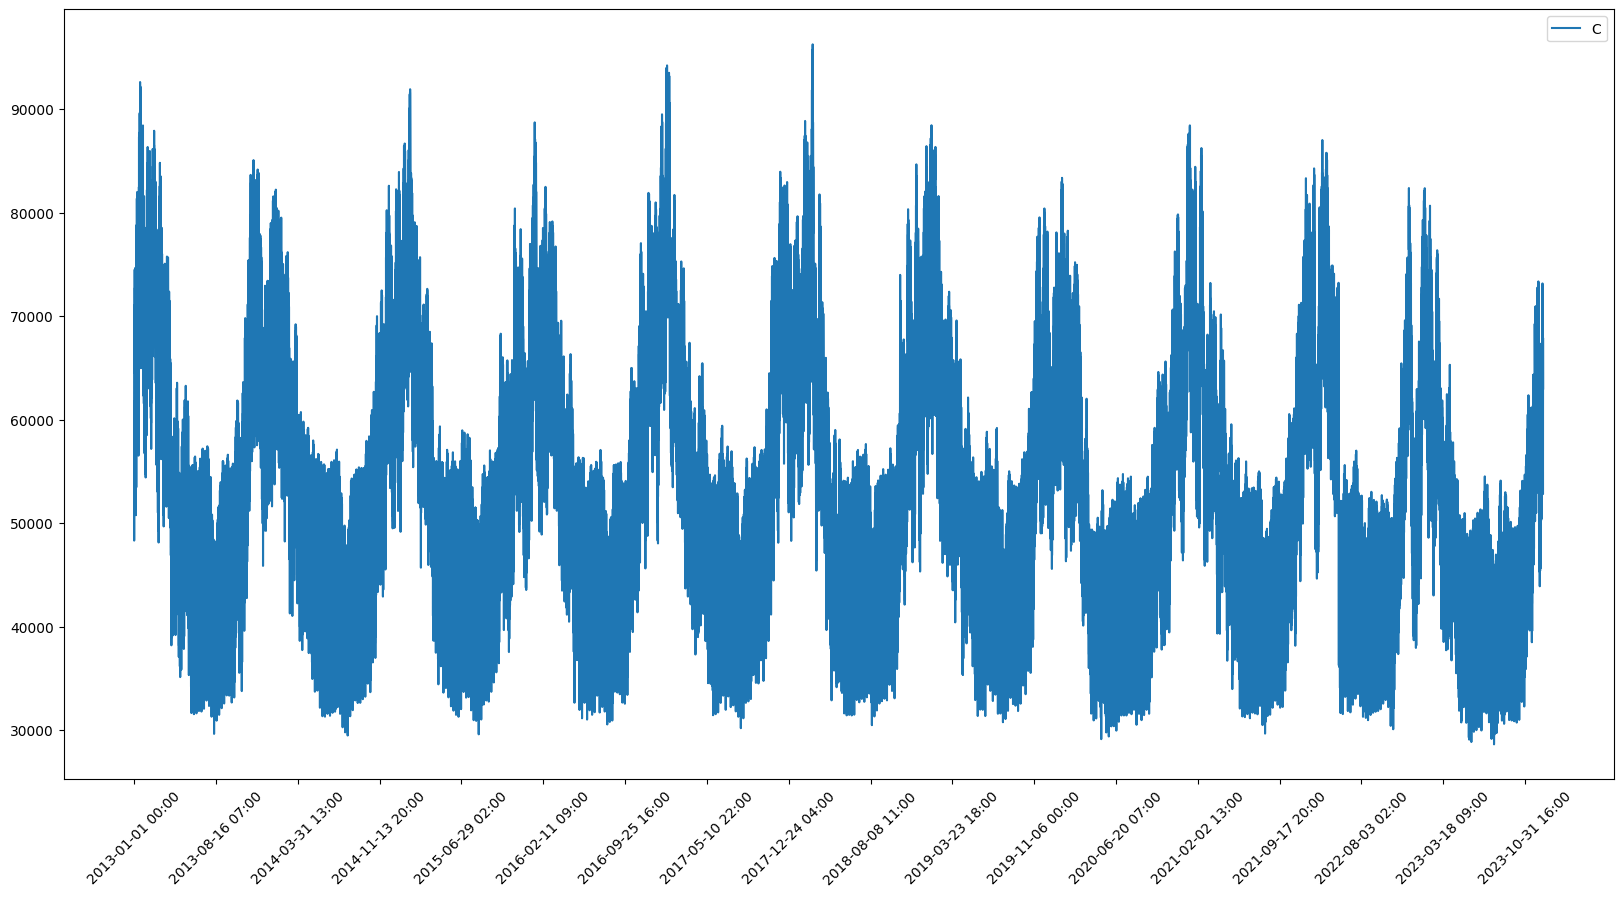

In [25]:
#print plot just conso_national
plt.figure(figsize=(20,10))
plt.plot(model_national["Consommation"])
plt.legend("Consommation nationale")
#just print key values from x label
plt.xticks(model_national.index[::10000], model_national.index[::10000], rotation=45)
plt.show()


## Création du modèle régional

In [18]:
#création des modèles finaux régionaux pour chaque région avec toutes les données
model_Auvergne = pd.DataFrame()
model_Bourgogne = pd.DataFrame()
model_Bretagne = pd.DataFrame()
model_Centre = pd.DataFrame()
model_Est = pd.DataFrame()
model_Hauts = pd.DataFrame()
model_Paris = pd.DataFrame()
model_Normandie = pd.DataFrame()
model_Aquitaine = pd.DataFrame()
model_Occitanie = pd.DataFrame()
model_PACA = pd.DataFrame()
model_Loire = pd.DataFrame()

for region in REGIONS:
    df = pd.concat([conso_regional[["index", f"Consommation_{region}"]], nb_habitants[f"{region}"]], axis=1, join="inner")
    df = pd.concat([df, regional_meteo[f"Temperature_{region}"]], axis=1, join="inner")
    df = df.set_index("index")
    if region == "Auvergne-Rhône-Alpes":
        model_Auvergne = df
    elif region == "Bourgogne-Franche-Comté":
        model_Bourgogne = df
    elif region == "Bretagne":
        model_Bretagne = df
    elif region == "Centre-Val-de-Loire":
        model_Centre = df
    elif region == "Grand-Est":
        model_Est = df
    elif region == "Hauts-de-France":
        model_Hauts = df
    elif region == "Ile-de-France":
        model_Paris = df
    elif region == "Normandie":
        model_Normandie = df
    elif region == "Nouvelle-Aquitaine":
        model_Aquitaine = df
    elif region == "Occitanie":
        model_Occitanie = df
    elif region == "PACA":
        model_PACA = df
    elif region == "Pays-de-la-Loire":
        model_Loire = df

In [21]:
model_Loire

,Consommation_Pays-de-la-Loire,Pays-de-la-Loire,Temperature_Pays-de-la-Loire
index,,,
2013-01-01 00:00:00,3595.0,4.953675e+06,4.950000
2013-01-01 00:30:00,3595.0,4.953677e+06,4.583333
2013-01-01 01:00:00,3359.0,4.953678e+06,4.216667
2013-01-01 01:30:00,3313.0,4.953680e+06,3.850000
2013-01-01 02:00:00,3383.0,4.953682e+06,3.483333
...,...,...,...
2022-09-15 22:00:00,2352.0,5.160082e+06,4.205462
2022-09-15 22:30:00,2516.0,5.160084e+06,4.204097
2022-09-15 23:00:00,2686.0,5.160086e+06,4.202731


## Prédiction modèle national

### Création d'un modèle de train et de test national
#### Partie test sur la journée du 20/12/2023, dernière donnée nationale

In [32]:
#En test, on met la dernière journée de consommation car c'est ce que l'on doit chercher à prédire pour le projet
model_national = model_national[model_national.index >= "2019-01-01"]
train = model_national[model_national.index < "2023-12-19 14:00"]
test = model_national[model_national.index >= "2023-12-19 14:00"]

In [32]:
test #on a bien la dernière journée de consommation

,Consommation,France,Temperature
index,,,
2023-12-19 14:00,68010.0,6.580112e+07,7.715402
2023-12-19 14:30,67032.0,6.580113e+07,7.715000
2023-12-19 16:00,65377.0,6.580114e+07,7.714597
2023-12-19 16:30,64855.0,6.580115e+07,7.714195
2023-12-19 17:00,65234.0,6.580116e+07,7.713793
2023-12-19 17:30,67468.0,6.580118e+07,7.713390
2023-12-19 18:00,68304.0,6.580119e+07,7.712988
2023-12-19 18:30,69366.0,6.580120e+07,7.712586
2023-12-19 19:00,70522.0,6.580121e+07,7.712183


In [ ]:
national = model_national.reset_index()
#keep left 4 characters of index
national["index"] = national["index"].astype(str).str[:4]
years = national["index"].unique()

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=national.loc[national["index"]==y, :], label=y)
        plt.text(national.loc[national["index"]==y, :].shape[0]-.9, national.loc[national["index"]==y, 'value'][-1:].values[0], y, fontsize=12)

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

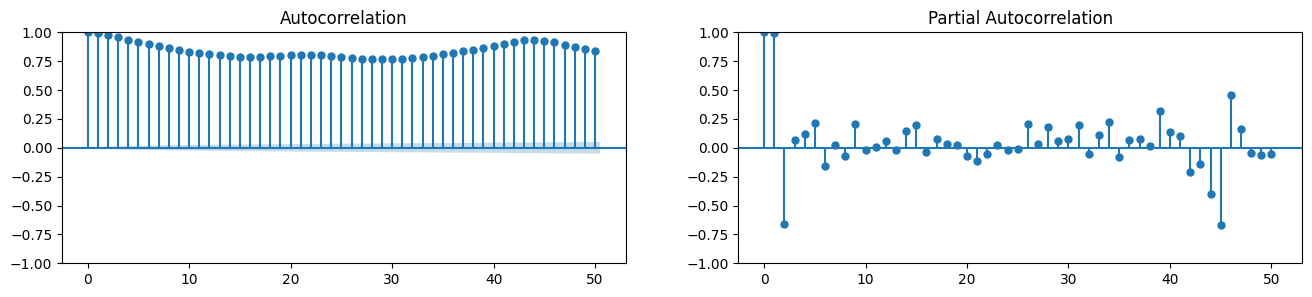

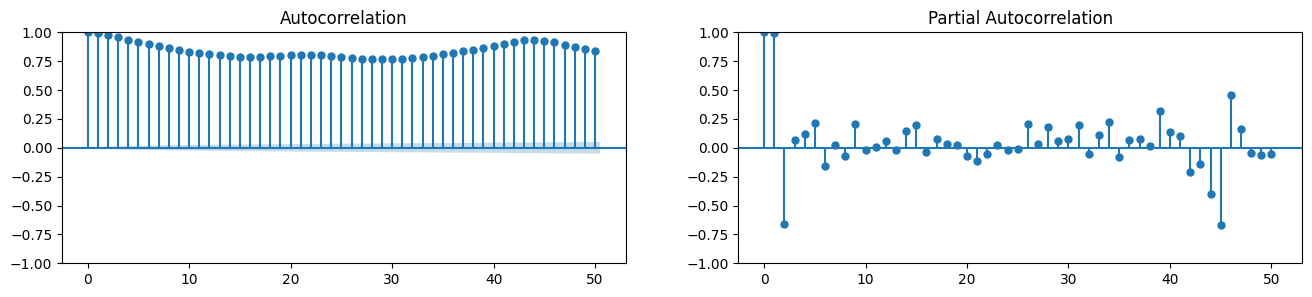

In [27]:
#Autocorrelation and Partial Autocorrelation Functions 
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Plot autocorrelation and partial autocorrelation
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(model_national["Consommation"].tolist(), lags=50, ax=axes[0])
plot_pacf(model_national["Consommation"].tolist(), lags=50, ax=axes[1])
#

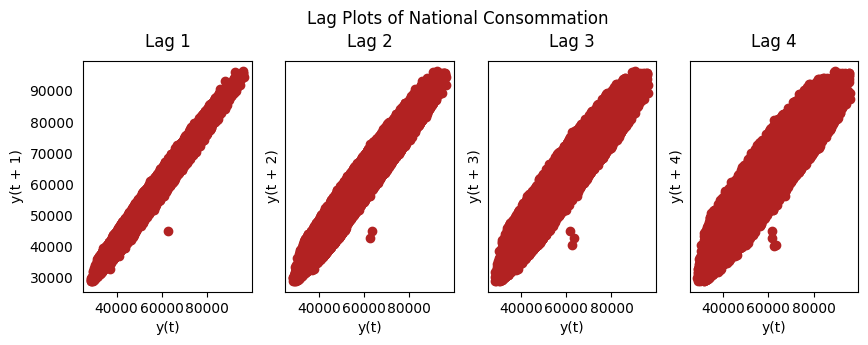

In [27]:
#Un diagramme de décalage est un diagramme de dispersion d'une série temporelle par rapport à son propre décalage. 
#S'il existe un modèle dans la série, celle-ci est autocorrélée. Dans le cas contraire, il s'agit probablement d'un bruit blanc aléatoire.
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(conso_national["Consommation"], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of National Consommation', y=1.05)    
plt.show() #on voit que la consommation est autocorrélée.

In [36]:
model = auto_arima(train["Consommation"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train["Consommation"])
forecast = model.predict(n_periods=len(test["Consommation"]))
forecast = pd.DataFrame(forecast,index = test["Consommation"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1255651.195, Time=32.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1303655.236, Time=2.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1259460.413, Time=4.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1268134.994, Time=28.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1303653.236, Time=1.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1258439.698, Time=14.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1256944.042, Time=32.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1252218.079, Time=88.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1254124.983, Time=87.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1251565.424, Time=31.38 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1251636.154, Time=31.65 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1251599.294, Time=34.79 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1250097.611, Time=60.95 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1250236.

In [37]:
print(model.summary())
#Ljung-Box test : test de significativité des autocorrélations supérieur à 0.05
#On peut dire que le modèle est bon pour prédire la consommation nationale

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                75750
Model:               SARIMAX(5, 1, 4)   Log Likelihood             -623419.396
Date:                Tue, 23 Jan 2024   AIC                        1246860.793
Time:                        09:52:16   BIC                        1246962.380
Sample:                             0   HQIC                       1246892.012
                              - 75750                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0879      0.231      0.381      0.703      -0.365       0.540
ar.L1          1.2122      0.007    184.630      0.000       1.199       1.225
ar.L2         -0.5642      0.013    -42.731      0.0

c:\Users\inesf\OneDrive\Documents\temporal-data-analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\inesf\OneDrive\Documents\temporal-data-analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\inesf\OneDrive\Documents\temporal-data-analysis\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Consommation   No. Observations:                80344
Model:                 ARIMA(5, 1, 2)   Log Likelihood             -668384.597
Date:                Sun, 14 Jan 2024   AIC                        1336785.193
Time:                        12:31:37   BIC                        1336859.546
Sample:                             0   HQIC                       1336807.982
                              - 80344                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4410      0.340      1.297      0.195      -0.225       1.107
ar.L2          0.5019      0.010     49.696      0.000       0.482       0.522
ar.L3         -0.1906      0.164     -1.165      0.2

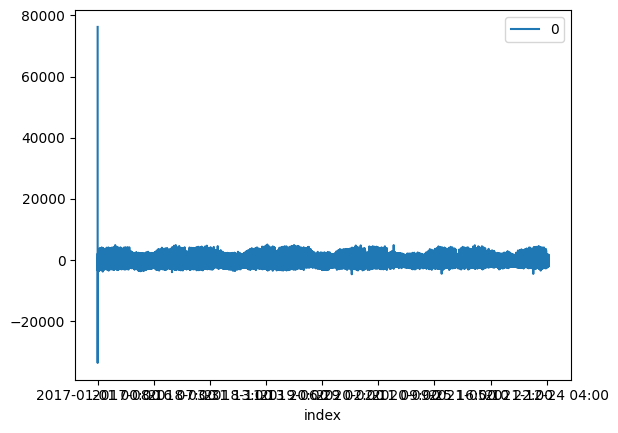

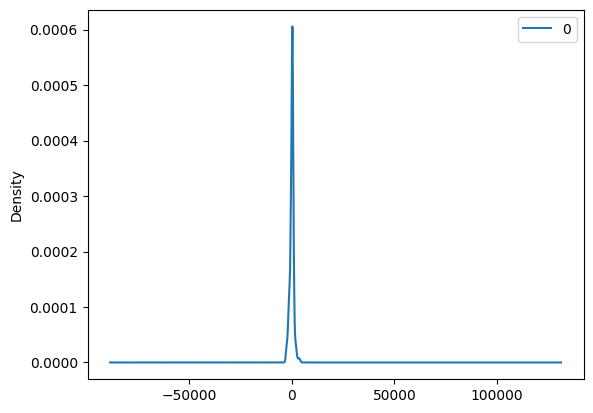

                  0
count  80344.000000
mean       0.583528
std     1030.357072
min   -33676.372169
25%     -480.049249
50%      107.388733
75%      527.306403
max    76259.000000


In [33]:
# fit model
model = ARIMA(train["Consommation"], order=(5,1,4))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

#### On va alors prédire la journée du 20/12/2023 en utilisant le modèle qui donne le meilleur AIC (5,1,4).

predicted=67766.371247, expected=68010.000000
predicted=67794.083802, expected=67032.000000
predicted=66289.454851, expected=65377.000000
predicted=64192.462913, expected=64855.000000
predicted=64311.557326, expected=65234.000000
predicted=65531.501531, expected=67468.000000
predicted=69356.056780, expected=68304.000000
predicted=68840.435789, expected=69366.000000
predicted=69804.040955, expected=70522.000000
predicted=70310.933525, expected=69537.000000
predicted=68894.183950, expected=67728.000000
predicted=66637.406468, expected=65726.000000
predicted=64218.299160, expected=63703.000000
predicted=61953.109742, expected=62279.000000
predicted=61511.861622, expected=61216.000000
predicted=61063.036735, expected=61490.000000
predicted=62218.867260, expected=61943.000000
predicted=62093.503921, expected=60961.000000
predicted=60276.901756, expected=60326.000000
predicted=60021.474730, expected=59120.000000
predicted=58604.963958, expected=56798.000000
predicted=55717.304194, expected=5

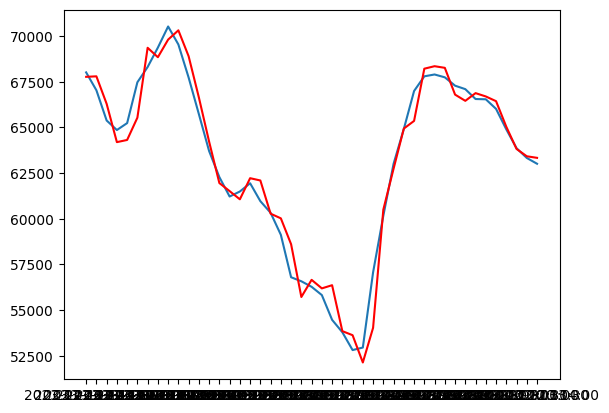

In [38]:
#Prediction avec le modèle ARIMA choisi par auto_arima
history = train["Consommation"].tolist()
test = test["Consommation"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,4))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Même chose mais en prenant en compte les covariables, ici la température

predicted=67752.020485, expected=68010.000000
predicted=67765.137827, expected=67032.000000
predicted=66281.614059, expected=65377.000000
predicted=64163.850050, expected=64855.000000
predicted=64272.129135, expected=65234.000000
predicted=65513.174146, expected=67468.000000
predicted=69382.030566, expected=68304.000000
predicted=68843.146892, expected=69366.000000
predicted=69838.802001, expected=70522.000000
predicted=70317.133738, expected=69537.000000
predicted=68884.896592, expected=67728.000000
predicted=66638.015936, expected=65726.000000
predicted=64194.432933, expected=63703.000000
predicted=61946.089712, expected=62279.000000
predicted=61524.600425, expected=61216.000000
predicted=61064.777622, expected=61490.000000
predicted=62186.380185, expected=61943.000000
predicted=62075.699655, expected=60961.000000
predicted=60273.945766, expected=60326.000000
predicted=60013.214050, expected=59120.000000
predicted=58632.648427, expected=56798.000000
predicted=55733.048765, expected=5

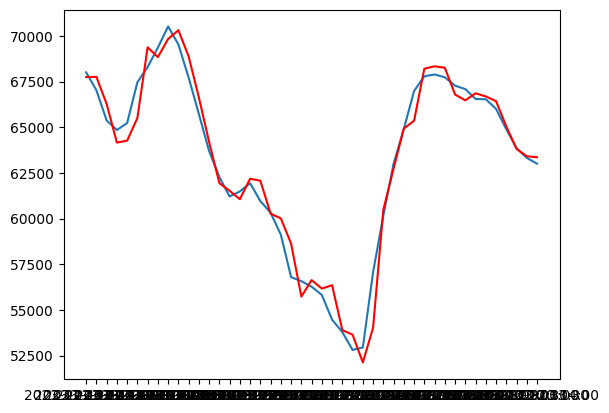

In [110]:
#Même chose mais en prenant en compte les covariables, ici la température
history = train["Consommation"].tolist()
predictions = list()
train_exog = train["Temperature"].tolist()
test_exog = test["Temperature"]
test = test["Consommation"]
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,4), exog=train_exog)
 model_fit = model.fit()
 output = model_fit.forecast(exog=test_exog[t])
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 obs_exog = test_exog[t]
 train_exog.append(obs_exog)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show() #ajouter la température ne permet pas d'améliorer la prédiction (RMSE)

In [25]:
model_national.to_csv(r"C:\Users\inesf\OneDrive\Documents\model_national.csv", index=False)

## Prédiction modèles régionaux

### Création de modèles de test et de train pour chaque région
#### Partie test sur la journée du 15/09/2022, dernière donnée régionale

In [23]:
#En test, on met la dernière journée de consommation car c'est ce que l'on doit chercher à prédire pour le projet
model_Auvergne = model_Auvergne[model_Auvergne.index >= "2019-01-01"]
train_Auvergne = model_Auvergne[model_Auvergne.index < "2022-09-15"]
test_Auvergne = model_Auvergne[model_Auvergne.index >= "2022-09-15"]
model_Bourgogne = model_Bourgogne[model_Bourgogne.index >= "2019-01-01"]
train_Bourgogne = model_Bourgogne[model_Bourgogne.index < "2022-09-15"]
test_Bourgogne = model_Bourgogne[model_Bourgogne.index >= "2022-09-15"]
model_Bretagne = model_Bretagne[model_Bretagne.index >= "2019-01-01"]
train_Bretagne = model_Bretagne[model_Bretagne.index < "2022-09-15"]
test_Bretagne = model_Bretagne[model_Bretagne.index >= "2022-09-15"]
model_Centre = model_Centre[model_Centre.index >= "2019-01-01"]
train_Centre = model_Centre[model_Centre.index < "2022-09-15"]
test_Centre = model_Centre[model_Centre.index >= "2022-09-15"]
model_Est = model_Est[model_Est.index >= "2019-01-01"]
train_Est = model_Est[model_Est.index < "2022-09-15"]
test_Est = model_Est[model_Est.index >= "2022-09-15"]
model_Hauts = model_Hauts[model_Hauts.index >= "2019-01-01"]
train_Hauts = model_Hauts[model_Hauts.index < "2022-09-15"]
test_Hauts = model_Hauts[model_Hauts.index >= "2022-09-15"]
model_Paris = model_Paris[model_Paris.index >= "2019-01-01"]
train_Paris = model_Paris[model_Paris.index < "2022-09-15"]
test_Paris = model_Paris[model_Paris.index >= "2022-09-15"]
model_Normandie = model_Normandie[model_Normandie.index >= "2019-01-01"]
train_Normandie = model_Normandie[model_Normandie.index < "2022-09-15"]
test_Normandie = model_Normandie[model_Normandie.index >= "2022-09-15"]
model_Aquitaine = model_Aquitaine[model_Aquitaine.index >= "2019-01-01"]
train_Aquitaine = model_Aquitaine[model_Aquitaine.index < "2022-09-15"]
test_Aquitaine = model_Aquitaine[model_Aquitaine.index >= "2022-09-15"]
model_Occitanie = model_Occitanie[model_Occitanie.index >= "2019-01-01"]
train_Occitanie = model_Occitanie[model_Occitanie.index < "2022-09-15"]
test_Occitanie = model_Occitanie[model_Occitanie.index >= "2022-09-15"]
model_PACA = model_PACA[model_PACA.index >= "2019-01-01"]
train_PACA = model_PACA[model_PACA.index < "2022-09-15"]
test_PACA = model_PACA[model_PACA.index >= "2022-09-15"]
model_Loire = model_Loire[model_Loire.index >= "2019-01-01"]
train_Loire = model_Loire[model_Loire.index < "2022-09-15"]
test_Loire = model_Loire[model_Loire.index >= "2022-09-15"]

#### Auvergne

In [112]:
model = auto_arima(train_Auvergne["Consommation_Auvergne-Rhône-Alpes"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_Auvergne["Consommation_Auvergne-Rhône-Alpes"])
forecast = model.predict(n_periods=len(test_Auvergne["Consommation_Auvergne-Rhône-Alpes"]))
forecast = pd.DataFrame(forecast,index = test_Auvergne["Consommation_Auvergne-Rhône-Alpes"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=771946.296, Time=11.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=787828.383, Time=0.78 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=772450.929, Time=1.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=776076.240, Time=6.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=787826.388, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=772085.657, Time=5.91 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=772261.647, Time=15.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=770654.677, Time=43.72 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=771996.178, Time=11.92 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=771999.925, Time=18.59 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=770654.058, Time=54.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=771846.463, Time=15.28 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=66.87 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=770497.041, Time=65.08 sec
 AR

#### On va alors prédire la journée du 15/09/2022 en utilisant le modèle qui donne le meilleur AIC (4,1,5)

predicted=5780.264345, expected=5613.000000
predicted=5490.218989, expected=5490.000000
predicted=5416.310916, expected=5330.000000
predicted=5252.216828, expected=5423.000000
predicted=5472.415574, expected=5425.000000
predicted=5467.767152, expected=5344.000000
predicted=5310.896077, expected=5343.000000
predicted=5313.981024, expected=5298.000000
predicted=5254.310670, expected=5222.000000
predicted=5189.517572, expected=5264.000000
predicted=5310.919433, expected=5604.000000
predicted=5784.657909, expected=5730.000000
predicted=5800.256807, expected=5927.000000
predicted=5983.432359, expected=6108.000000
predicted=6181.595359, expected=6234.000000
predicted=6298.907920, expected=6264.000000
predicted=6293.607165, expected=6447.000000
predicted=6528.096343, expected=6625.000000
predicted=6700.897646, expected=6661.000000
predicted=6669.372829, expected=6650.000000
predicted=6642.744153, expected=6958.000000
predicted=7100.492919, expected=7001.000000
predicted=7046.243354, expected=

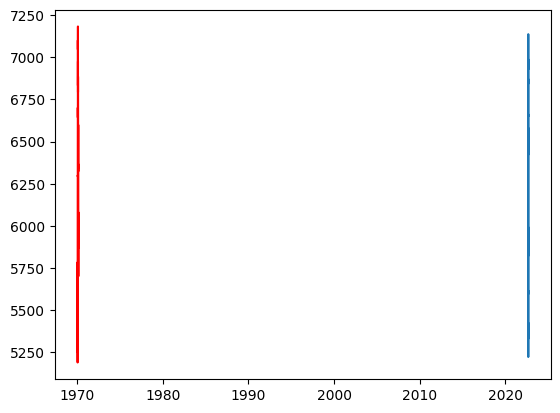

In [114]:
history = train_Auvergne["Consommation_Auvergne-Rhône-Alpes"].tolist()
test = test_Auvergne["Consommation_Auvergne-Rhône-Alpes"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(4,1,5))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

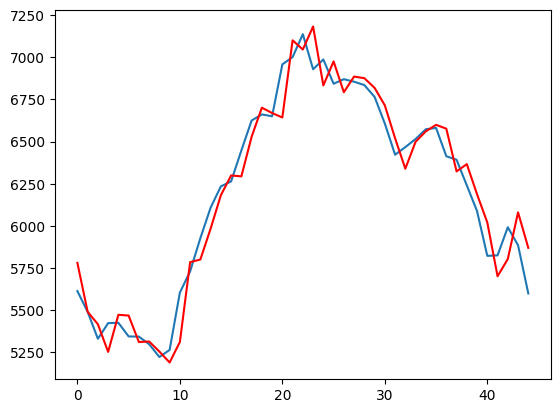

In [123]:
test = test.reset_index()
test = test.drop(columns="index")
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Nouvelle-Aquitaine

In [125]:
model = auto_arima(train_Aquitaine["Consommation_Nouvelle-Aquitaine"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_Aquitaine["Consommation_Nouvelle-Aquitaine"])
forecast = model.predict(n_periods=len(test_Aquitaine["Consommation_Nouvelle-Aquitaine"]))
forecast = pd.DataFrame(forecast,index = test_Aquitaine["Consommation_Nouvelle-Aquitaine"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=754982.900, Time=24.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=770146.585, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=762073.257, Time=0.83 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=764521.718, Time=8.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=770144.590, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=757762.430, Time=15.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=759899.300, Time=5.83 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=754958.675, Time=30.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=758003.754, Time=24.58 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=754102.679, Time=19.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=754317.373, Time=11.13 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=753966.027, Time=37.90 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=754003.409, Time=34.77 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=753048.456, Time=38.48 

predicted=3930.300293, expected=3851.000000
predicted=3790.297192, expected=3741.000000
predicted=3672.476505, expected=3639.000000
predicted=3630.050059, expected=3675.000000
predicted=3717.315331, expected=3559.000000
predicted=3595.498235, expected=3566.000000
predicted=3589.304881, expected=3326.000000
predicted=3260.516031, expected=3255.000000
predicted=3239.088773, expected=3174.000000
predicted=3151.690383, expected=3178.000000
predicted=3284.629339, expected=3481.000000
predicted=3615.816920, expected=3664.000000
predicted=3854.498989, expected=3979.000000
predicted=4137.906409, expected=4130.000000
predicted=4199.123552, expected=4248.000000
predicted=4282.637922, expected=4304.000000
predicted=4281.944303, expected=4430.000000
predicted=4461.236371, expected=4498.000000
predicted=4520.735921, expected=4615.000000
predicted=4665.567743, expected=4647.000000
predicted=4626.891938, expected=4644.000000
predicted=4619.383288, expected=4736.000000
predicted=4693.360006, expected=

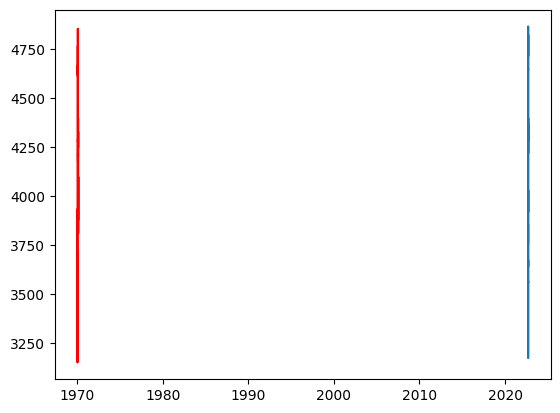

In [23]:
history = train_Aquitaine["Consommation_Nouvelle-Aquitaine"].tolist()
test = test_Aquitaine["Consommation_Nouvelle-Aquitaine"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,4))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

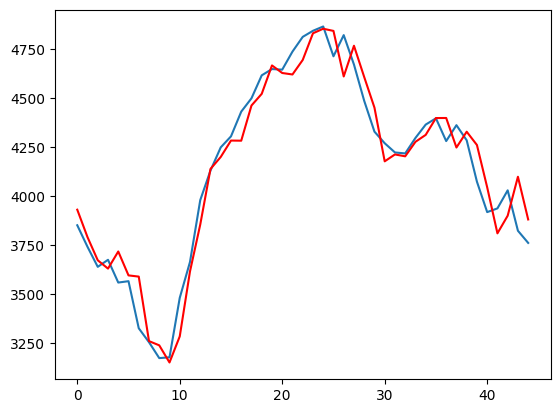

In [25]:
test = test.reset_index()
test = test.drop(columns="index")
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Bourgogne

In [29]:
model = auto_arima(train_Bourgogne["Consommation_Bourgogne-Franche-Comté"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_Bourgogne["Consommation_Bourgogne-Franche-Comté"])
forecast = model.predict(n_periods=len(test_Bourgogne["Consommation_Bourgogne-Franche-Comté"]))
forecast = pd.DataFrame(forecast,index = test_Bourgogne["Consommation_Bourgogne-Franche-Comté"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=663960.738, Time=31.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=675747.657, Time=0.98 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=664722.809, Time=1.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=666167.787, Time=7.99 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=675745.658, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=664572.905, Time=11.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=664608.625, Time=20.98 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=71.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=662713.168, Time=25.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=663129.862, Time=26.42 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=662691.580, Time=42.28 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=662378.462, Time=95.88 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=662765.082, Time=53.41 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=662310.275, Time=108.77 sec
 

predicted=1903.020824, expected=1827.000000
predicted=1818.309209, expected=1750.000000
predicted=1718.120479, expected=1698.000000
predicted=1640.807455, expected=1737.000000
predicted=1741.785736, expected=1806.000000
predicted=1860.781063, expected=1759.000000
predicted=1771.671417, expected=1692.000000
predicted=1648.594559, expected=1702.000000
predicted=1662.017896, expected=1614.000000
predicted=1577.966124, expected=1696.000000
predicted=1773.496485, expected=1780.000000
predicted=1818.785965, expected=1916.000000
predicted=1958.820226, expected=2019.000000
predicted=2036.100122, expected=2151.000000
predicted=2230.584316, expected=2192.000000
predicted=2227.146896, expected=2321.000000
predicted=2377.311695, expected=2266.000000
predicted=2208.696077, expected=2259.000000
predicted=2266.118111, expected=2295.000000
predicted=2308.855769, expected=2365.000000
predicted=2416.838239, expected=2319.000000
predicted=2289.847607, expected=2412.000000
predicted=2445.553435, expected=

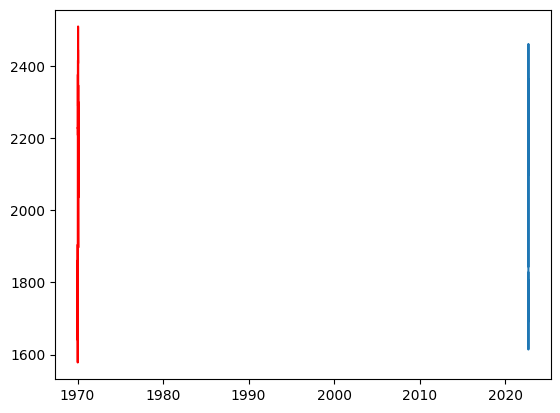

In [31]:
history = train_Bourgogne["Consommation_Bourgogne-Franche-Comté"].tolist()
test = test_Bourgogne["Consommation_Bourgogne-Franche-Comté"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(4,1,3))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

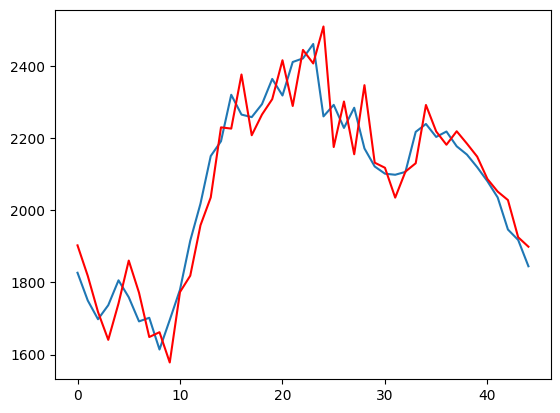

In [32]:
test = test.reset_index()
test = test.drop(columns="index")
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Bretagne

In [34]:
model = auto_arima(train_Bretagne["Consommation_Bretagne"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_Bretagne["Consommation_Bretagne"])
forecast = model.predict(n_periods=len(test_Bretagne["Consommation_Bretagne"]))
forecast = pd.DataFrame(forecast,index = test_Bretagne["Consommation_Bretagne"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=714933.196, Time=43.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=724445.118, Time=0.77 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=718999.079, Time=0.89 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=720630.357, Time=2.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=724443.120, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=716927.792, Time=6.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=716087.370, Time=15.84 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=713092.506, Time=36.97 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=715995.895, Time=29.52 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=65.84 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=52.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=715118.655, Time=31.77 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=712951.780, Time=43.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=716894.167, Time=3.63 sec
 ARIMA(5,1,

predicted=2160.386834, expected=2235.000000
predicted=2243.816391, expected=2053.000000
predicted=2008.175756, expected=1868.000000
predicted=1771.519790, expected=1857.000000
predicted=1845.809314, expected=1903.000000
predicted=1882.336046, expected=1774.000000
predicted=1800.647012, expected=1694.000000
predicted=1700.299413, expected=1638.000000
predicted=1609.976630, expected=1626.000000
predicted=1596.058055, expected=1649.000000
predicted=1689.258061, expected=1833.000000
predicted=1901.170247, expected=1976.000000
predicted=2058.957200, expected=2124.000000
predicted=2189.892783, expected=2302.000000
predicted=2371.504281, expected=2290.000000
predicted=2269.619688, expected=2316.000000
predicted=2287.949681, expected=2361.000000
predicted=2341.195987, expected=2375.000000
predicted=2337.168944, expected=2381.000000
predicted=2393.513255, expected=2344.000000
predicted=2328.408323, expected=2400.000000
predicted=2395.441839, expected=2402.000000
predicted=2409.361344, expected=

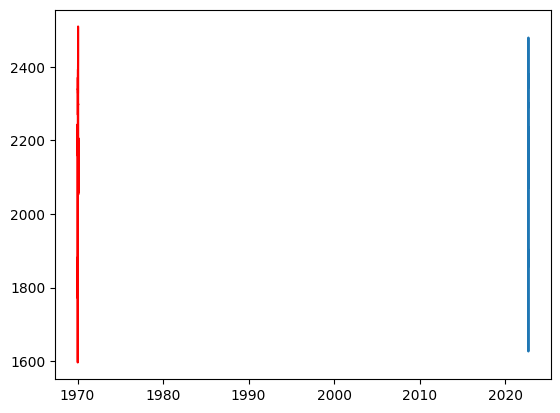

In [35]:
history = train_Bretagne["Consommation_Bretagne"].tolist()
test = test_Bretagne["Consommation_Bretagne"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,2))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

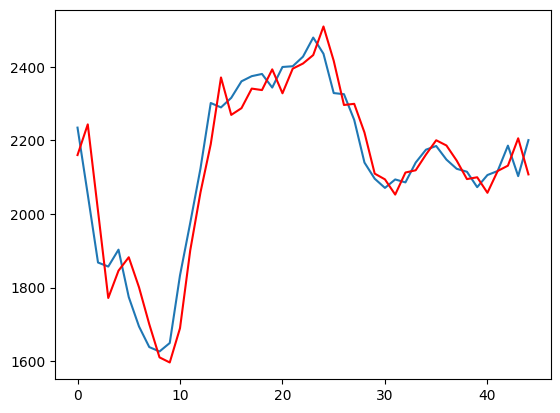

In [36]:
test = test.reset_index()
test = test.drop(columns="index")
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Centre

In [37]:
model = auto_arima(train_Centre["Consommation_Centre-Val-de-Loire"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_Centre["Consommation_Centre-Val-de-Loire"])
forecast = model.predict(n_periods=len(test_Centre["Consommation_Centre-Val-de-Loire"]))
forecast = pd.DataFrame(forecast,index = test_Centre["Consommation_Centre-Val-de-Loire"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=657523.658, Time=22.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=672187.791, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=660066.742, Time=0.86 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=662606.962, Time=6.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=672185.794, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=659716.663, Time=6.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=659806.497, Time=8.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=652906.748, Time=50.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=659615.355, Time=16.46 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=655547.610, Time=51.78 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=66.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=652959.098, Time=49.84 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=655775.633, Time=33.16 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=655544.456, Time=49.31 sec
 ARI

In [38]:
history = train_Centre["Consommation_Centre-Val-de-Loire"].tolist()
test = test_Centre["Consommation_Centre-Val-de-Loire"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(3, 1, 2))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=1781.065786, expected=1758.000000
predicted=1769.135813, expected=1667.000000
predicted=1641.992091, expected=1559.000000
predicted=1514.066655, expected=1555.000000
predicted=1533.639043, expected=1483.000000
predicted=1440.378624, expected=1449.000000
predicted=1423.534547, expected=1415.000000
predicted=1399.974370, expected=1363.000000
predicted=1356.701286, expected=1348.000000
predicted=1357.947894, expected=1337.000000
predicted=1353.033369, expected=1508.000000
predicted=1571.684581, expected=1633.000000
predicted=1687.711318, expected=1797.000000
predicted=1851.189126, expected=1835.000000
predicted=1852.988952, expected=1777.000000
predicted=1752.760700, expected=1860.000000
predicted=1863.512572, expected=1895.000000
predicted=1883.852790, expected=1905.000000
predicted=1895.475252, expected=1880.000000
predicted=1869.235371, expected=1849.000000
predicted=1846.031943, expected=1878.000000
predicted=1899.161060, expected=1897.000000
predicted=1921.414922, expected=

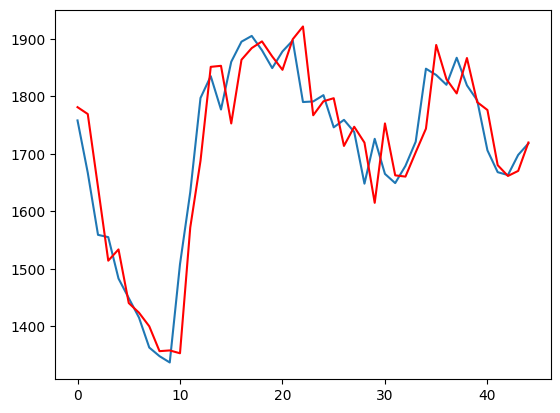

In [39]:
test = test.reset_index()
test = test.drop(columns="index")
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Est

In [40]:
model = auto_arima(train_Est["Consommation_Grand-Est"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_Est["Consommation_Grand-Est"])
forecast = model.predict(n_periods=len(test_Est["Consommation_Grand-Est"]))
forecast = pd.DataFrame(forecast,index = test_Est["Consommation_Grand-Est"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=734739.843, Time=12.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=747172.244, Time=0.94 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=736846.950, Time=1.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=739861.299, Time=5.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=747170.246, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=735155.967, Time=5.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=735607.174, Time=8.99 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=734731.454, Time=16.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=733368.087, Time=28.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=735301.996, Time=2.57 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=734731.796, Time=19.51 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=735814.489, Time=1.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=734763.800, Time=3.56 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=52.90 sec
 ARIMA(

In [41]:
history = train_Est["Consommation_Grand-Est"].tolist()
test = test_Est["Consommation_Grand-Est"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(3,1,1))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=3909.355199, expected=3967.000000
predicted=3978.754482, expected=3929.000000
predicted=3942.850131, expected=3863.000000
predicted=3858.770654, expected=3830.000000
predicted=3833.719866, expected=3764.000000
predicted=3764.559144, expected=3725.000000
predicted=3730.553441, expected=3642.000000
predicted=3639.991522, expected=3622.000000
predicted=3635.059907, expected=3617.000000
predicted=3646.801282, expected=3603.000000
predicted=3632.052055, expected=3845.000000
predicted=3952.916325, expected=4139.000000
predicted=4297.959920, expected=4174.000000
predicted=4244.710510, expected=4317.000000
predicted=4370.675279, expected=4607.000000
predicted=4719.865949, expected=4629.000000
predicted=4669.774075, expected=4730.000000
predicted=4744.294270, expected=4783.000000
predicted=4792.352009, expected=4864.000000
predicted=4871.015801, expected=4910.000000
predicted=4907.770592, expected=4846.000000
predicted=4800.866270, expected=4860.000000
predicted=4823.025742, expected=

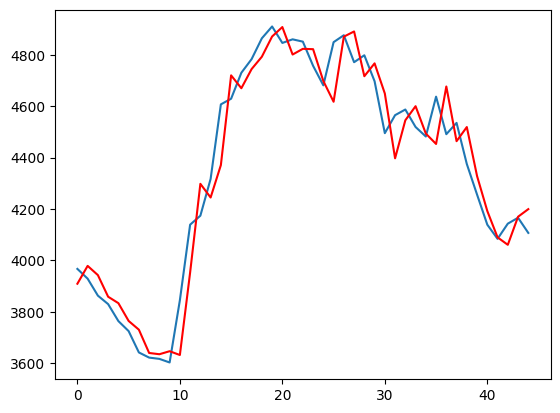

In [42]:
test = test.reset_index()
test = test.drop(columns="index")
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Hauts-de-France

In [43]:
model = auto_arima(train_Hauts["Consommation_Hauts-de-France"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_Hauts["Consommation_Hauts-de-France"])
forecast = model.predict(n_periods=len(test_Hauts["Consommation_Hauts-de-France"]))
forecast = pd.DataFrame(forecast,index = test_Hauts["Consommation_Hauts-de-France"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=739617.430, Time=39.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=759646.231, Time=0.62 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=748660.817, Time=0.78 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=751994.304, Time=6.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=759644.234, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=746421.826, Time=5.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=747172.729, Time=9.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=743094.871, Time=50.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=738125.086, Time=45.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=745560.728, Time=10.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=54.94 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=70.97 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=743367.174, Time=40.22 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=738084.225, Time=67.24 sec
 ARIMA(4,1,

In [44]:
history = train_Hauts["Consommation_Hauts-de-France"].tolist()
test = test_Hauts["Consommation_Hauts-de-France"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(4,1,5))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=4336.323680, expected=4334.000000
predicted=4394.271472, expected=4135.000000
predicted=4110.298086, expected=4023.000000
predicted=3958.539970, expected=3982.000000
predicted=3915.700067, expected=3883.000000
predicted=3790.142587, expected=3705.000000
predicted=3603.878625, expected=3728.000000
predicted=3722.426861, expected=3709.000000
predicted=3722.021726, expected=3645.000000
predicted=3693.612424, expected=3475.000000
predicted=3517.734296, expected=3818.000000
predicted=3938.001302, expected=4135.000000
predicted=4251.165504, expected=4282.000000
predicted=4320.561459, expected=4401.000000
predicted=4397.265506, expected=4556.000000
predicted=4548.672286, expected=4482.000000
predicted=4393.247694, expected=4487.000000
predicted=4437.908061, expected=4508.000000
predicted=4487.196104, expected=4596.000000
predicted=4602.583379, expected=4653.000000
predicted=4717.269884, expected=4706.000000
predicted=4769.112844, expected=4687.000000
predicted=4736.575814, expected=

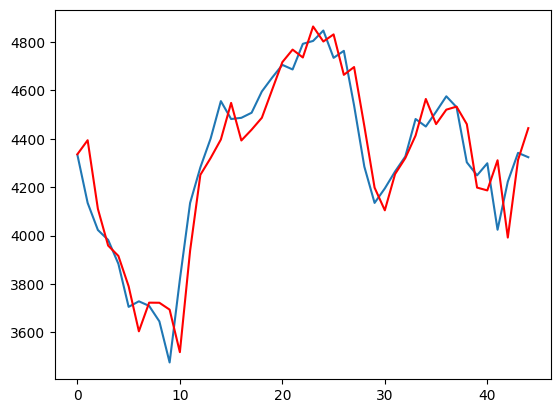

In [45]:
test = test.reset_index()
test = test.drop(columns="index")
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Ile-de-France

In [22]:
model = auto_arima(train_Paris["Consommation_Ile-de-France"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_Paris["Consommation_Ile-de-France"])
forecast = model.predict(n_periods=len(test_Paris["Consommation_Ile-de-France"]))
forecast = pd.DataFrame(forecast,index = test_Paris["Consommation_Ile-de-France"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=789262.570, Time=34.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=824287.830, Time=0.63 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=793338.874, Time=1.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=802061.975, Time=6.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=824285.832, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=793211.220, Time=5.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=793231.233, Time=7.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=789298.089, Time=33.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=789584.080, Time=30.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=793232.313, Time=3.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=790691.858, Time=9.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=792464.956, Time=23.76 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=788294.277, Time=30.26 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=787895.678, Time=62.73 sec

In [23]:
history = train_Paris["Consommation_Ile-de-France"].tolist()
test = test_Paris["Consommation_Ile-de-France"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,4))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=6284.659565, expected=6085.000000
predicted=5990.711308, expected=5695.000000
predicted=5365.532421, expected=5385.000000
predicted=5137.037760, expected=4991.000000
predicted=4811.147030, expected=4986.000000
predicted=5118.075113, expected=4730.000000
predicted=4629.311226, expected=4621.000000
predicted=4586.913441, expected=4598.000000
predicted=4554.130507, expected=4458.000000
predicted=4537.972857, expected=4533.000000
predicted=4689.106264, expected=5036.000000
predicted=5393.578304, expected=5539.000000
predicted=5859.872224, expected=5885.000000
predicted=6255.218507, expected=6389.000000
predicted=6740.811736, expected=6647.000000
predicted=6798.419256, expected=6865.000000
predicted=6932.012209, expected=6950.000000
predicted=7002.710560, expected=7060.000000
predicted=7134.422183, expected=7117.000000
predicted=7132.467311, expected=7158.000000
predicted=7116.335322, expected=7194.000000
predicted=7161.897195, expected=7211.000000
predicted=7208.542217, expected=

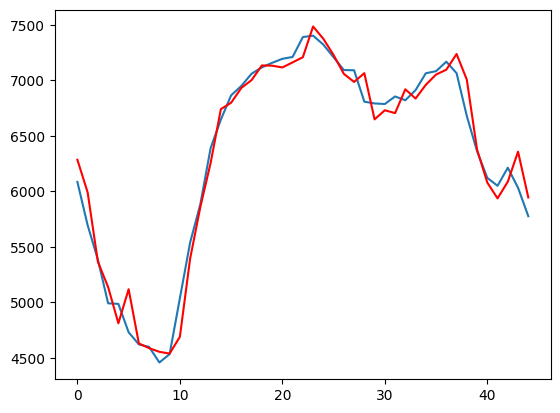

In [24]:
test = test.reset_index()
test = test.drop(columns="index")
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Normandie

In [25]:
model = auto_arima(train_Normandie["Consommation_Normandie"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_Normandie["Consommation_Normandie"])
forecast = model.predict(n_periods=len(test_Normandie["Consommation_Normandie"]))
forecast = pd.DataFrame(forecast,index = test_Normandie["Consommation_Normandie"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=685054.301, Time=20.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=700449.353, Time=0.63 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=686615.935, Time=0.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=688710.074, Time=5.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=700447.355, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=686207.936, Time=6.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=683739.060, Time=17.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=686327.613, Time=3.61 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=686336.455, Time=1.90 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=683761.248, Time=16.78 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=686127.474, Time=2.54 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=681045.441, Time=41.59 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=679516.808, Time=16.45 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=679598.085, Time=16.42 sec

In [26]:
history = train_Normandie["Consommation_Normandie"].tolist()
test = test_Normandie["Consommation_Normandie"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,5))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=2820.932029, expected=2726.000000
predicted=2653.965101, expected=2579.000000
predicted=2505.408069, expected=2499.000000
predicted=2455.870432, expected=2511.000000
predicted=2517.389952, expected=2429.000000
predicted=2454.395172, expected=2352.000000
predicted=2345.229088, expected=2324.000000
predicted=2297.086277, expected=2272.000000
predicted=2255.648819, expected=2278.000000
predicted=2325.919446, expected=2245.000000
predicted=2263.469307, expected=2419.000000
predicted=2525.694518, expected=2571.000000
predicted=2638.866442, expected=2709.000000
predicted=2832.602676, expected=2778.000000
predicted=2799.944650, expected=2782.000000
predicted=2759.679437, expected=2875.000000
predicted=2880.683954, expected=2855.000000
predicted=2827.072153, expected=2887.000000
predicted=2942.466974, expected=2919.000000
predicted=2882.600432, expected=2911.000000
predicted=2915.327680, expected=2936.000000
predicted=2916.320180, expected=2946.000000
predicted=2934.046541, expected=

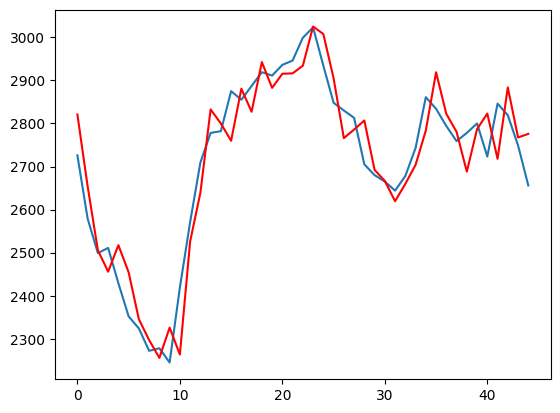

In [27]:
test = test.reset_index()
test = test.drop(columns="index") 
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Occitanie

In [28]:
model = auto_arima(train_Occitanie["Consommation_Occitanie"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_Occitanie["Consommation_Occitanie"])
forecast = model.predict(n_periods=len(test_Occitanie["Consommation_Occitanie"]))
forecast = pd.DataFrame(forecast,index = test_Occitanie["Consommation_Occitanie"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=745009.126, Time=30.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=764023.822, Time=1.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=752182.383, Time=2.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=755581.230, Time=9.97 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=764021.827, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=748707.824, Time=20.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=39.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=744963.788, Time=39.93 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=746528.882, Time=40.83 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=744573.564, Time=28.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=745372.695, Time=26.44 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=744436.398, Time=44.34 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=745248.864, Time=40.36 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=744250.035, Time=65.00 sec
 A

In [30]:
history = train_Occitanie["Consommation_Occitanie"].tolist()
test = test_Occitanie["Consommation_Occitanie"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,5))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=3726.691966, expected=3604.000000
predicted=3454.759361, expected=3181.000000
predicted=2969.016250, expected=3031.000000
predicted=2957.546239, expected=2980.000000
predicted=3006.881262, expected=2969.000000
predicted=3153.282205, expected=3133.000000
predicted=3220.933446, expected=2994.000000
predicted=2994.808885, expected=2957.000000
predicted=2929.916053, expected=2888.000000
predicted=2831.466023, expected=2861.000000
predicted=2979.626631, expected=3076.000000
predicted=3190.527664, expected=3269.000000
predicted=3448.523926, expected=3549.000000
predicted=3705.724125, expected=3707.000000
predicted=3748.421477, expected=3645.000000
predicted=3657.791542, expected=3799.000000
predicted=3741.366692, expected=3950.000000
predicted=4040.873493, expected=3755.000000
predicted=3757.309436, expected=3856.000000
predicted=3804.063731, expected=4151.000000
predicted=4246.510981, expected=4157.000000
predicted=4215.346371, expected=4197.000000
predicted=4240.340171, expected=

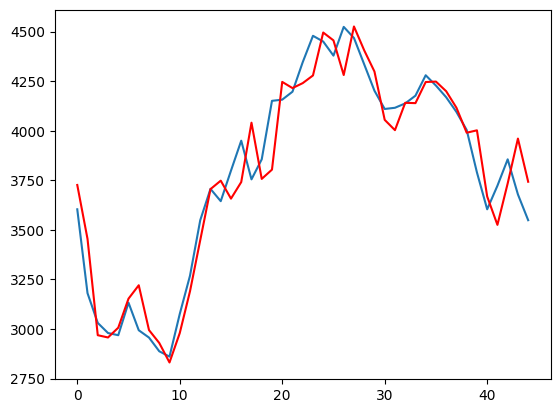

In [31]:
test = test.reset_index()
test = test.drop(columns="index") 
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### PACA

In [32]:
model = auto_arima(train_PACA["Consommation_PACA"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_PACA["Consommation_PACA"])
forecast = model.predict(n_periods=len(test_PACA["Consommation_PACA"]))
forecast = pd.DataFrame(forecast,index = test_PACA["Consommation_PACA"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=753993.657, Time=11.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=764415.239, Time=1.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=756223.304, Time=1.70 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=758015.243, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=764413.242, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=754276.837, Time=7.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=755035.644, Time=19.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=753390.272, Time=15.75 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=753464.508, Time=10.44 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=753370.463, Time=29.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=753407.875, Time=23.42 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=751749.252, Time=73.77 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=753340.984, Time=28.08 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=751485.177, Time=94.72 

In [33]:
history = train_PACA["Consommation_PACA"].tolist()
test = test_PACA["Consommation_PACA"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,3))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=4289.639882, expected=3876.000000
predicted=3755.109913, expected=3687.000000
predicted=3557.941341, expected=3508.000000
predicted=3465.964441, expected=3486.000000
predicted=3497.248663, expected=3500.000000
predicted=3592.930875, expected=3610.000000
predicted=3604.932389, expected=3347.000000
predicted=3238.564845, expected=3373.000000
predicted=3374.331107, expected=3296.000000
predicted=3335.417146, expected=3244.000000
predicted=3172.610588, expected=3473.000000
predicted=3582.484445, expected=3530.000000
predicted=3586.386963, expected=3778.000000
predicted=3829.958561, expected=3849.000000
predicted=3878.010494, expected=3933.000000
predicted=3895.279450, expected=4035.000000
predicted=4087.980724, expected=4125.000000
predicted=4108.955896, expected=4201.000000
predicted=4239.560595, expected=4275.000000
predicted=4311.843166, expected=4452.000000
predicted=4479.742987, expected=4458.000000
predicted=4453.313708, expected=4513.000000
predicted=4520.316637, expected=

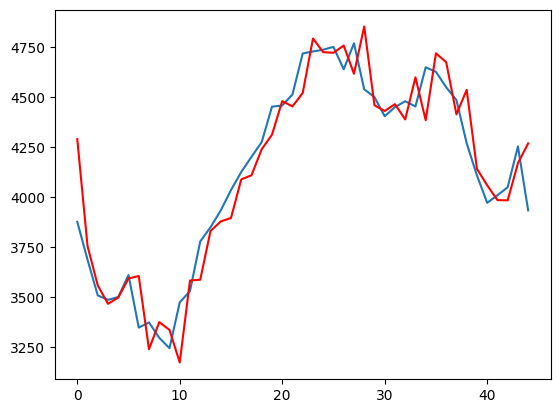

In [34]:
test = test.reset_index()
test = test.drop(columns="index") 
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### Pays-de-la-Loire

In [35]:
model = auto_arima(train_Loire["Consommation_Pays-de-la-Loire"], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_Loire["Consommation_Pays-de-la-Loire"])
forecast = model.predict(n_periods=len(test_Loire["Consommation_Pays-de-la-Loire"]))
forecast = pd.DataFrame(forecast,index = test_Loire["Consommation_Pays-de-la-Loire"].index,columns=['Prediction'])
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=731457.606, Time=21.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=743443.174, Time=0.65 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=733929.954, Time=0.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=735212.761, Time=5.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=743441.176, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=733761.430, Time=5.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=731370.274, Time=16.86 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=733809.235, Time=3.96 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=733806.938, Time=1.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=733101.499, Time=9.37 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=733754.771, Time=1.64 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=727591.018, Time=42.63 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=727097.324, Time=19.69 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=728933.207, Time=12.12 sec


In [36]:
history = train_Loire["Consommation_Pays-de-la-Loire"].tolist()
test = test_Loire["Consommation_Pays-de-la-Loire"]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,3))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=2537.292394, expected=2537.000000
predicted=2501.864058, expected=2402.000000
predicted=2314.393095, expected=2231.000000
predicted=2209.477094, expected=2256.000000
predicted=2289.133142, expected=2239.000000
predicted=2227.401666, expected=2122.000000
predicted=2127.723054, expected=2041.000000
predicted=2060.969769, expected=1994.000000
predicted=1975.096324, expected=1966.000000
predicted=1990.926347, expected=1987.000000
predicted=2072.964007, expected=2237.000000
predicted=2356.599094, expected=2439.000000
predicted=2545.844566, expected=2646.000000
predicted=2783.513564, expected=2776.000000
predicted=2837.022656, expected=2866.000000
predicted=2860.056876, expected=2851.000000
predicted=2844.112534, expected=2926.000000
predicted=2951.382779, expected=2940.000000
predicted=2902.545929, expected=2921.000000
predicted=2882.230762, expected=2943.000000
predicted=2945.989980, expected=2972.000000
predicted=2955.167535, expected=2953.000000
predicted=2906.745633, expected=

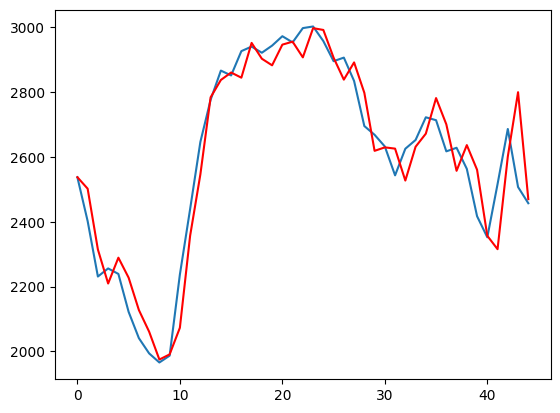

In [37]:
test = test.reset_index()
test = test.drop(columns="index") 
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### Récapitulatif des modèles

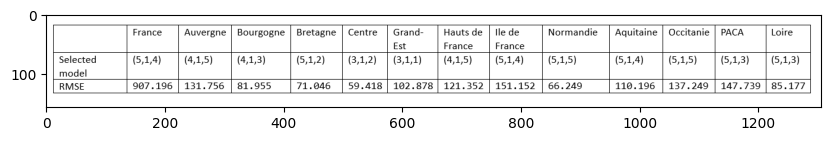

In [4]:
plt.figure(figsize=(10,6))
image = mpimg.imread("recapitulatif_all_models.PNG")
plt.imshow(image)
plt.show()

### Extraction du modèle final pour chaque région avec toutes les données afin de tester gtop

In [19]:
#Extraction du modèle final pour chaque région avec toutes les données afin de tester gtop
model_regionaux = pd.DataFrame()
for region in REGIONS:
    df = pd.concat([conso_regional[["index", f"Consommation_{region}"]]], axis=1, join="inner")
    df = df.set_index("index")
    model_regionaux = pd.concat([model_regionaux, df], axis=1)
print(model_regionaux)
model_regionaux.to_csv(r"C:\Users\inesf\OneDrive\Documents\model_regionaux.csv", index=False)

                     Consommation_Auvergne-Rhône-Alpes  \
index                                                    
2013-01-01 00:00:00                             8173.0   
2013-01-01 00:30:00                             8173.0   
2013-01-01 01:00:00                             7944.0   
2013-01-01 01:30:00                             7896.0   
2013-01-01 02:00:00                             7882.0   
...                                                ...   
2023-12-20 06:30:00                             8553.0   
2023-12-20 07:00:00                             8872.0   
2023-12-20 07:30:00                             8950.0   
2023-12-20 08:00:00                             9214.0   
2023-12-20 08:30:00                             9270.0   

                     Consommation_Bourgogne-Franche-Comté  \
index                                                       
2013-01-01 00:00:00                                2357.0   
2013-01-01 00:30:00                                2357.0   
2

In [22]:
#get last row of model_regionaux and model_national
mod = model_regionaux.reset_index()
#keep row where index = "2023-12-20 08:30:00"
mod = mod[mod["index"] == "2023-12-20 08:30:00"]
#delete index column
test = mod.drop(columns=["index"])
#add column 
test

,Consommation_Auvergne-Rhône-Alpes,Consommation_Bourgogne-Franche-Comté,Consommation_Bretagne,Consommation_Centre-Val-de-Loire,Consommation_Grand-Est,Consommation_Hauts-de-France,Consommation_Ile-de-France,Consommation_Normandie,Consommation_Nouvelle-Aquitaine,Consommation_Occitanie,Consommation_PACA,Consommation_Pays-de-la-Loire
176235,9270.0,2946.0,3232.0,2775.0,5796.0,6561.0,10904.0,3551.0,6921.0,6036.0,5433.0,4158.0


In [23]:
model_regionaux = model_regionaux[model_regionaux.index >= "2019-01-01"]
train_regionaux = model_regionaux[model_regionaux.index < "2022-09-15"]
train_regionaux

,Consommation_Auvergne-Rhône-Alpes,Consommation_Bourgogne-Franche-Comté,Consommation_Bretagne,Consommation_Centre-Val-de-Loire,Consommation_Grand-Est,Consommation_Hauts-de-France,Consommation_Ile-de-France,Consommation_Normandie,Consommation_Nouvelle-Aquitaine,Consommation_Occitanie,Consommation_PACA,Consommation_Pays-de-la-Loire
index,,,,,,,,,,,,
2019-01-01 00:00:00,8984.0,2613.0,3327.0,2707.0,5123.0,6095.0,9035.0,3714.0,6513.0,6132.0,6259.0,3704.0
2019-01-01 00:30:00,8815.0,2510.0,3230.0,2727.0,5034.0,6064.0,8875.0,3622.0,6586.0,5963.0,6061.0,3674.0
2019-01-01 01:00:00,8576.0,2454.0,3000.0,2616.0,4903.0,5836.0,8506.0,3490.0,6391.0,5763.0,5902.0,3485.0
2019-01-01 01:30:00,8526.0,2500.0,2883.0,2668.0,4940.0,5960.0,8186.0,3505.0,6543.0,5678.0,5891.0,3448.0
2019-01-01 02:00:00,8474.0,2549.0,2979.0,2584.0,4983.0,5809.0,7992.0,3480.0,6341.0,5622.0,5839.0,3473.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-14 21:30:00,5967.0,2182.0,2132.0,1842.0,4168.0,4233.0,6716.0,2835.0,4108.0,3802.0,4061.0,2502.0
2022-09-14 22:00:00,5801.0,2129.0,2125.0,1734.0,4116.0,4262.0,6504.0,2779.0,3992.0,3653.0,3920.0,2416.0
2022-09-14 22:30:00,5933.0,2045.0,2173.0,1716.0,4198.0,4135.0,6395.0,2874.0,4043.0,3747.0,3854.0,2584.0


In [29]:
# walk-forward validation
for i in range(len(test.columns)):
 predictions = list()
 history = train_regionaux.iloc[:,i].tolist()
 model = ARIMA(history)
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output
 predictions.append(yhat)
 obs = test.iloc[:,i]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
 # evaluate forecasts
 rmse = sqrt(mean_squared_error(obs, predictions))
 print('Test RMSE: %.3f' % rmse)

predicted=7341.224988, expected=9270.000000
Test RMSE: 1928.775
predicted=2375.568283, expected=2946.000000
Test RMSE: 570.432
predicted=2570.965262, expected=3232.000000
Test RMSE: 661.035
predicted=2127.281916, expected=2775.000000
Test RMSE: 647.718
predicted=5034.222788, expected=5796.000000
Test RMSE: 761.777
predicted=5536.153262, expected=6561.000000
Test RMSE: 1024.847
predicted=7714.405345, expected=10904.000000
Test RMSE: 3189.595
predicted=3090.468084, expected=3551.000000
Test RMSE: 460.532
predicted=4897.196651, expected=6921.000000
Test RMSE: 2023.803
predicted=4321.667977, expected=6036.000000
Test RMSE: 1714.332
predicted=4632.047319, expected=5433.000000
Test RMSE: 800.953
predicted=3039.568249, expected=4158.000000
Test RMSE: 1118.432


In [35]:
#same for national
train_national = model_national[model_national.index < "2022-09-15"]
test = model_national.reset_index()
#keep row where index = "2023-12-20 08:30:00"
test = test[test["index"] == "2023-12-20 08:30"]
#delete index column
test = test.drop(columns=["index","France","Temperature"])
#add column 
test

,Consommation
75783,67794.0


In [38]:
# walk-forward validation
predictions = list()
history = train_national["Consommation"].tolist()
model = ARIMA(history, order=(5,1,4))
model_fit = model.fit()
output = model_fit.forecast()
yhat = output
predictions.append(yhat)
obs = test["Consommation"]
history.append(obs)
print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(obs, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=43642.484517, expected=67794.000000
Test RMSE: 24151.515


## Réconciliation
On souhaite observer l'effet de la réconciliation sur notre système de prévision. 

Lien pour accéder à la partie avec gtop : https://colab.research.google.com/drive/15p4Pn8bfFii8BISbSIaYog4VDwijVxbP?usp=sharing